<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Alphas/Filter_Rules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Investigation of Filter Rules
---
## Load useful packages...

In [1]:
from my_library import *

14:43:47 Starting...
14:43:47 Installing yfinance into Google notebook...
14:43:55 Installing arch into Google notebook...
14:44:07 Initialized.


## Get S&P 500 Index Data from Yahoo! Finance

In [2]:
nprint("Fetching data from Yahoo!...")
data,sname=download(ticker:='SPY','1990-01-02','2019-12-31',auto_adjust=True,progress=False),'S&P 500 Index ETF'
data.columns=data.columns.get_level_values(0)
data.columns.name=ticker
data.index=pd.PeriodIndex(data.index,freq='B')
data['Return']=data['Close'].pct_change()*hundred
data.dropna(inplace=True)
display(data)

14:44:07 Fetching data from Yahoo!...


<ipython-input-2-eadee26bc247>:5: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  data.index=pd.PeriodIndex(data.index,freq='B')


SPY,Close,High,Low,Open,Volume,Return
Date,,,,,,
1993-02-01,24.626432,24.626432,24.469908,24.469908,480500,0.711216
1993-02-02,24.678614,24.696005,24.556873,24.609047,201300,0.211891
1993-02-03,24.939482,24.956873,24.696000,24.713392,529400,1.057061
1993-02-04,25.043821,25.095996,24.748165,25.026430,531500,0.418371
1993-02-05,25.026434,25.078609,24.887302,25.026434,492100,-0.069428
...,...,...,...,...,...,...
2019-12-23,296.917694,297.315155,296.769796,297.259697,52990000,0.152781
2019-12-24,296.926910,297.194950,296.621861,297.148744,20270000,0.003104
2019-12-26,298.507568,298.516821,297.305933,297.315157,30911200,0.532339


## Fit baseline AR(1) GJR-AGARCH(1,1) model

In [3]:
from arch.univariate import ARX
model = ARX(data['Return'],lags=1)
model.volatility = GARCH2(0,1,1)
model.distribution = GeneralizedError2()
fit=model.fit(update_freq=0,disp='off')
nprint(fit.summary(),sep='\n')
display(baseline:=pd.DataFrame([fit.params,fit.std_err]).T)
data['Volatility']=fit.conditional_volatility
data['Alpha']=baseline.loc['Const','params']+baseline.loc['Return[1]','params']*data['Return'].shift()
data['Z Score']=(data['Return']-data['Alpha'])/data['Volatility'].shift()
display(data)
nprint("Baseline IC %.2f %%." % (hundred*fit.rsquared**half))

14:44:09
                               AR - GJR-GARCH Model Results                               
Dep. Variable:                             Return   R-squared:                       0.003
Mean Model:                                    AR   Adj. R-squared:                  0.003
Vol Model:                              GJR-GARCH   Log-Likelihood:               -8759.17
Distribution:      Generalized Error Distribution   AIC:                           17530.3
Method:                        Maximum Likelihood   BIC:                           17571.3
                                                    No. Observations:                 6777
Date:                            Tue, Mar 25 2025   Df Residuals:                     6775
Time:                                    14:44:09   Df Model:                            2
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
--------------

,params,std_err
Const,0.062286,0.009122
Return[1],-0.037914,0.013216
omega,0.017251,0.003156
gamma[1],0.187389,0.021783
beta[1],0.888963,0.011779
nu,1.348238,0.036889


SPY,Close,High,Low,Open,Volume,Return,Volatility,Alpha,Z Score
Date,,,,,,,,,
1993-02-01,24.626432,24.626432,24.469908,24.469908,480500,0.711216,NaN,NaN,NaN
1993-02-02,24.678614,24.696005,24.556873,24.609047,201300,0.211891,0.783946,0.035321,NaN
1993-02-03,24.939482,24.956873,24.696000,24.713392,529400,1.057061,0.750721,0.054252,1.279182
1993-02-04,25.043821,25.095996,24.748165,25.026430,531500,0.418371,0.719899,0.022209,0.527709
1993-02-05,25.026434,25.078609,24.887302,25.026434,492100,-0.069428,0.691347,0.046424,-0.160928
...,...,...,...,...,...,...,...,...,...
2019-12-23,296.917694,297.315155,296.769796,297.259697,52990000,0.152781,0.484165,0.045663,0.216725
2019-12-24,296.926910,297.194950,296.621861,297.148744,20270000,0.003104,0.475014,0.056493,-0.110271
2019-12-26,298.507568,298.516821,297.305933,297.315157,30911200,0.532339,0.467301,0.062168,0.989804


14:44:09 Baseline IC 5.46 %.


## Fit a Basic "Filter Rules" Model

In [4]:
# create filter rules summary holder, re-run this cell to reset dataframe
from itertools import product
summary=pd.DataFrame({tuple(x):[] for x in product(['Active','Inactive'],['Mean','St.Dev.','Count','Std.Err.'])},index=pd.Series([],name='Filter'))

14:51:04 Creating filter rule indicators with order 3 and offset 0.100000.
14:51:04 Conditional returns:


SPY,Close,High,Low,Open,Volume,Return,Volatility,Alpha,Z Score,Direction,...,Z_3,Direction_3,Filter_000,Filter_001,Filter_010,Filter_011,Filter_100,Filter_101,Filter_110,Filter_111
Date,,,,,,,,,,,,,,,,,,,,,
1993-02-01,24.626432,24.626432,24.469908,24.469908,480500,0.711216,NaN,NaN,NaN,0.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-02-02,24.678614,24.696005,24.556873,24.609047,201300,0.211891,0.783946,0.035321,NaN,0.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-02-03,24.939482,24.956873,24.696000,24.713392,529400,1.057061,0.750721,0.054252,1.279182,1.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-02-04,25.043821,25.095996,24.748165,25.026430,531500,0.418371,0.719899,0.022209,0.527709,1.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-02-05,25.026434,25.078609,24.887302,25.026434,492100,-0.069428,0.691347,0.046424,-0.160928,-1.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,296.917694,297.315155,296.769796,297.259697,52990000,0.152781,0.484165,0.045663,0.216725,1.0,...,-0.104145,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2019-12-24,296.926910,297.194950,296.621861,297.148744,20270000,0.003104,0.475014,0.056493,-0.110271,-1.0,...,0.672809,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2019-12-26,298.507568,298.516821,297.305933,297.315157,30911200,0.532339,0.467301,0.062168,0.989804,1.0,...,0.775054,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Active                               Inactive                      \
            Count      Mean   St.Dev.  Std.Err.    Count      Mean   St.Dev.   
Rule                                                                           
Filter_000  590.0  0.206878  1.566588  0.064495   6188.0  0.027767  1.092094   
Filter_101  598.0  0.102464  1.025831  0.041949   6180.0  0.037638  1.152782   
Filter_110  671.0  0.055104  0.928620  0.035849   6107.0  0.042067  1.163366   
Filter_001  643.0  0.052356  1.297106  0.051153   6135.0  0.042415  1.124876   
Filter_011  604.0  0.031707  0.981935  0.039954   6174.0  0.044498  1.156781   
Filter_100  669.0 -0.010809  1.254634  0.048507   6109.0  0.049290  1.129193   
Filter_010  620.0 -0.016510  1.187711  0.047700   6158.0  0.049385  1.137473   
Filter_111  586.0 -0.031905  0.921586  0.038070   6192.0  0.050481  1.160748   

                       Z Score  
            Std.Err.            
Rule                            
Filter_000  0.013883  2.714924  
Filter_101  0.014664  1.458761  
Filter_110  0.014887  0.335862  
Filter_001  0.014361  0.187110  
Filter_011  0.014722 -0.300380  
Filter_100  0.014447 -1.187422  
Filter_010  0.014495 -1.321787  
Filter_111  0.014751 -2.017859

14:51:05 Saved figure to '/content/drive/MyDrive/Subsequent Return Associated with Filter Rules.png'.


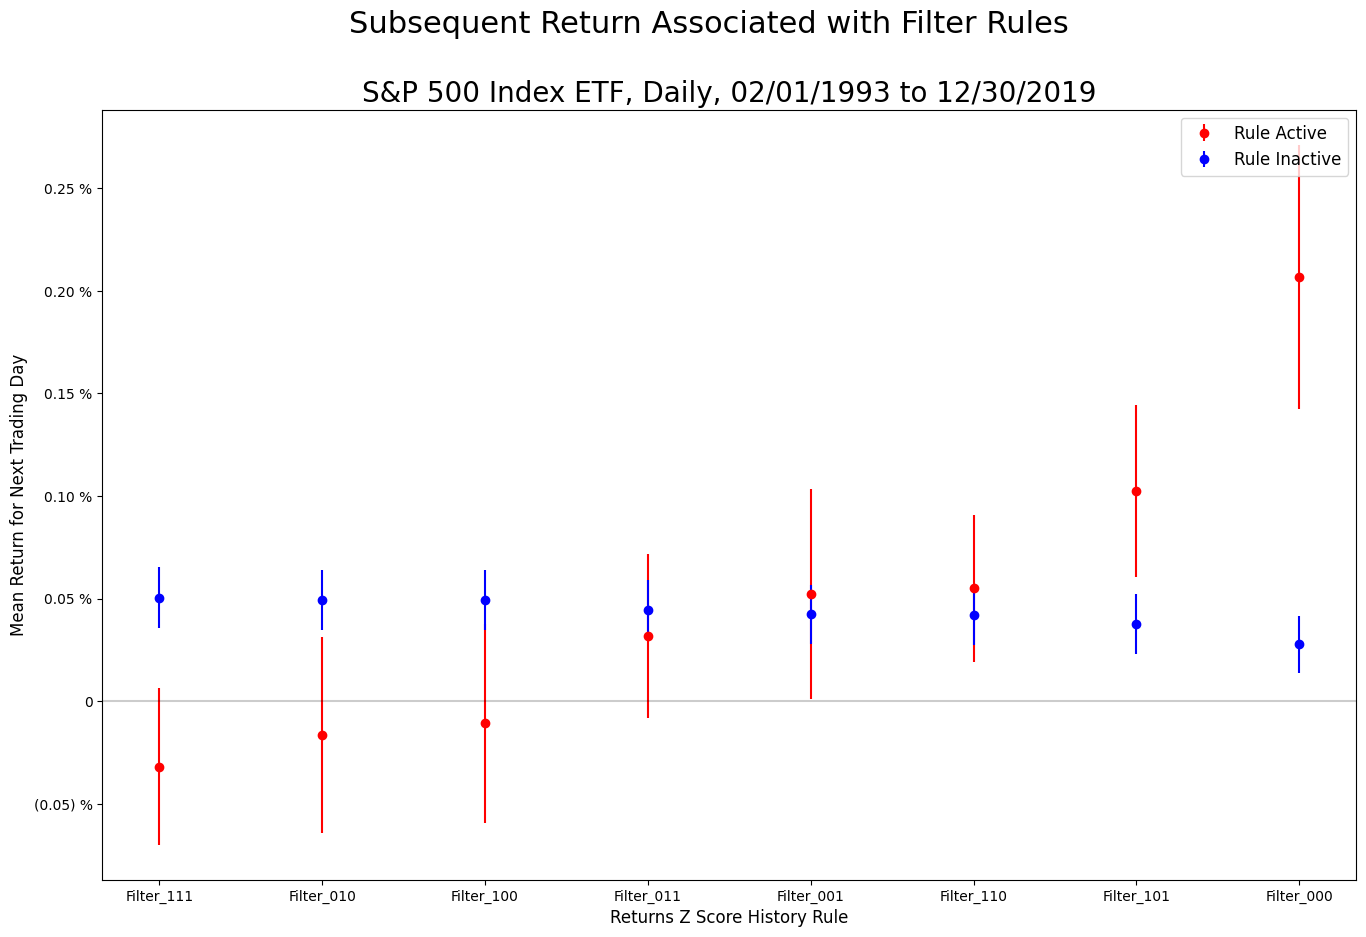

In [12]:
nprint("Creating filter rule indicators with order {:d} and offset {:f}.".format(forder:=3,foffset:=0.1))

data['Direction']=data['Z Score'].apply(lambda x: one if x>foffset else -one if x<-foffset else zero)
data.drop(data.columns[data.columns.str.contains('Filter')],axis=1,inplace=True)

for lag in range(1,forder+1):
    data['Z_'+str(lag)]=data['Z Score'].shift(lag)
    data['Direction_'+str(lag)]=data['Direction'].shift(lag)

for rule in range(2**forder):
    rmap=list(map(lambda x:-one if x=='0' else +one,label:="{:0#b}".replace("#",str(forder)).format(rule)))
    data['Filter_'+label]=(data['Direction_1']==rmap[0])

    for lag in range(2,forder+1):
        data['Filter_'+label]&=(data['Direction_'+str(lag)]==rmap[lag-1])

    data['Filter_'+label]=data['Filter_'+label].apply(lambda x:one if x else zero)

nprint("Conditional returns:")
display(data)

for f in data.columns[data.columns.str.contains('Filter')]:
    g=data[[f,'Return']].groupby(f)
    summary.loc[f,('Active','Mean')]=g.mean().loc[one,'Return']
    summary.loc[f,('Inactive','Mean')]=g.mean().loc[zero,'Return']
    summary.loc[f,('Active','St.Dev.')]=g.std().loc[one,'Return']
    summary.loc[f,('Inactive','St.Dev.')]=g.std().loc[zero,'Return']
    summary.loc[f,('Active','Count')]=g.count().loc[one,'Return']
    summary.loc[f,('Inactive','Count')]=g.count().loc[zero,'Return']

    for s in [c for c in set(summary.columns.get_level_values(0)) if c!='Z Score']:
        summary.loc[f,(s,'Std.Err.')]=summary.loc[f,(s,'St.Dev.')]/np.sqrt(summary.loc[f,(s,'Count')])

summary=summary[sorted(summary.columns)].copy()
summary['Z Score']=(summary['Active','Mean']-summary['Inactive','Mean'])/np.sqrt(summary['Active','Std.Err.']**two+summary['Inactive','Std.Err.']**two)
summary.index.name='Rule'
display(summary.sort_values('Z Score',ascending=False))

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(x:=summary.sort_values('Z Score').index,y:=summary.loc[x,('Active','Mean')],ye:=summary.loc[x,('Active','Std.Err.')],fmt='o',color='red',label='Rule Active')
plot.errorbar(x,y:=summary.loc[x,('Inactive','Mean')],ye:=summary.loc[x,('Inactive','Std.Err.')],fmt='o',color='blue',label='Rule Inactive')

if forder>3:
    plot.tick_params(axis='x',labelrotation=90)

plot.set_ylabel('Mean Return for Next Trading Day',fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(2))
plot.set_xlabel('Returns Z Score History Rule',fontsize=12)
plot.axhline(color='black',alpha=0.2)
figure.suptitle(title:='Subsequent Return Associated with Filter Rules',fontsize=22)
plot.set_title(subtitle:='{:s}, Daily, {:s} to {:s}'.format(sname,data.index[0].strftime("%m/%d/%Y"),data.index[-1].strftime("%m/%d/%Y")),fontsize=20)
plot.legend(fontsize=12)
figure.savefig(filename:=(filepath:='/content/drive/MyDrive/')+title+'.png',dpi=300,bbox_inches='tight')
nprint("Saved figure to '{:s}'.".format(filename))

14:51:53 Fitting GJR-GARCH model with filter rules...
14:51:54
                              AR-X - GJR-GARCH Model Results                              
Dep. Variable:                             Return   R-squared:                       0.002
Mean Model:                                  AR-X   Adj. R-squared:                  0.001
Vol Model:                              GJR-GARCH   Log-Likelihood:               -8751.07
Distribution:      Generalized Error Distribution   AIC:                           17528.1
Method:                        Maximum Likelihood   BIC:                           17616.8
                                                    No. Observations:                 6773
Date:                            Tue, Mar 25 2025   Df Residuals:                     6764
Time:                                    14:51:53   Df Model:                            9
                                   Mean Model                                  
                  coef    std err     

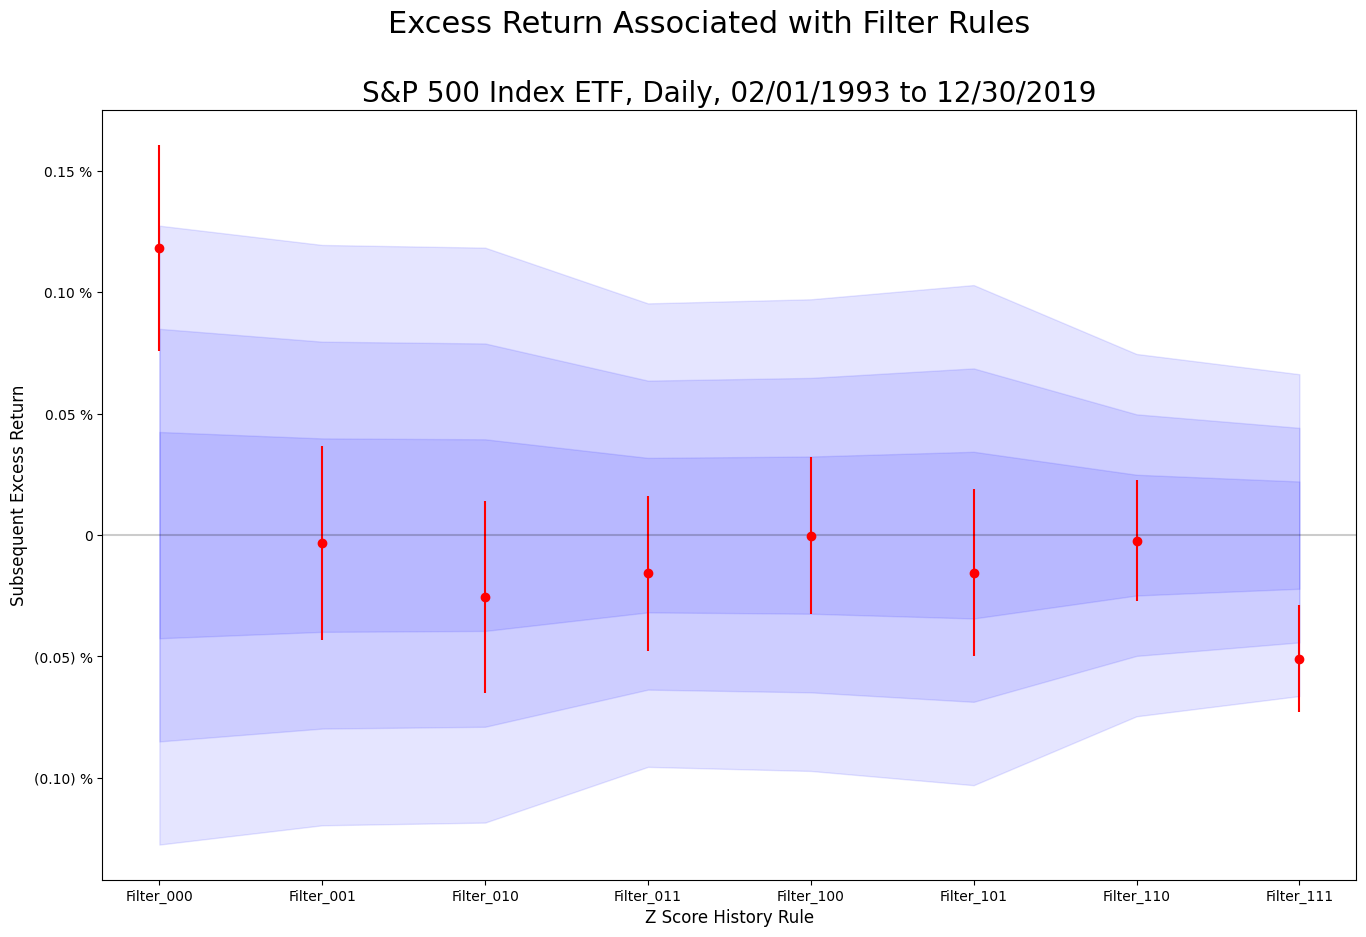

In [13]:
nprint("Fitting GJR-GARCH model with filter rules...")
model=ARX((design:=data.dropna())['Return'],design[fcols:=design.columns[design.columns.str.contains('Filter')]])
model.volatility=GARCH2(0,1,1)
model.distribution=GeneralizedError2()
fit=model.fit(update_freq=0,disp='off')
nprint(fit.summary(),sep='\n')
coefficients=pd.DataFrame([fit.params[fcols],fit.std_err[fcols]]).T

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(x:=coefficients.index,y:=coefficients['params'],ye:=coefficients['std_err'],fmt='o',color='red')
plot.axhline(color='black',alpha=0.2)
plot.set_ylabel('Subsequent Excess Return',fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(2))
plot.set_xlabel('Z Score History Rule',fontsize=12)
figure.suptitle(title:='Excess Return Associated with Filter Rules',fontsize=22)
plot.set_title(subtitle:='{:s}, Daily, {:s} to {:s}'.format(sname,data.index[0].strftime("%m/%d/%Y"),data.index[-1].strftime("%m/%d/%Y")),fontsize=20)

for s in range(1,4):
    plot.fill_between(x,-s*ye,y2=s*ye,alpha=0.1,color='blue')

if forder>3:
    plot.tick_params(axis='x',labelrotation=90)

figure.savefig(filename:=(filepath:='/content/drive/MyDrive/')+title+'.png',dpi=300,bbox_inches='tight')
nprint("Saved figure to '{:s}'.".format(filename))

### Fit a Conditional Model to (Filter_000 | Filter_111)

In [11]:
nprint("Fitting a fusion autoregression...")
data[fn:='Filter_000|111']=(data['Filter_000'].astype(bool)|data['Filter_111'].astype(bool)).astype(float)*data['Return'].shift()
model=ARX((design:=data.dropna())['Return'],design[fn])
model.volatility=GARCH2(0,1,1)
model.distribution=GeneralizedError2()
fit=model.fit(update_freq=0,disp='off')
nprint(fit.summary(),sep='\n')
nprint("In-sample IC is (%.2f +/- %.2f) %%" % (-data[['Return',fn]].replace(zero,np.nan).dropna().corr().iloc[0,1]*hundred,hundred/np.sqrt(data[['Return',fn]].replace(zero,np.nan).dropna().shape[0]-three)))

14:48:19 Fitting a fusion autoregression...
14:48:19
                              AR-X - GJR-GARCH Model Results                              
Dep. Variable:                             Return   R-squared:                       0.005
Mean Model:                                  AR-X   Adj. R-squared:                  0.005
Vol Model:                              GJR-GARCH   Log-Likelihood:               -8751.38
Distribution:      Generalized Error Distribution   AIC:                           17514.8
Method:                        Maximum Likelihood   BIC:                           17555.7
                                                    No. Observations:                 6773
Date:                            Tue, Mar 25 2025   Df Residuals:                     6771
Time:                                    14:48:19   Df Model:                            2
                                   Mean Model                                   
                     coef    std err          t

### Formulas for Article

$$
\alpha_t=\mathbb{E}[r_t|\mathcal{I}_s]:s<t
$$

$$
\alpha_t=f(\mathcal{I}_s)
$$

$$
f(\mathcal{I}_s)=\mu+\varphi r_{t-1}+\dots
$$

$$
\lim_{t\rightarrow\infty}\mathbb{E}[\alpha_t]=\mathbb{E}[r_t]
$$

$$
\overline{\{r_s : s<t\}}
$$

$$
\begin{align}
\alpha_t&=\mu+\varphi r_{t-1}\\
r_t&=\alpha_t+\sigma_t\varepsilon_t\\
\sigma_t^2&=C+B\sigma_{t-1}^2+Dr_{t-1}^2\mathbb{I}[r_{t-1}<0]\\
\varepsilon_t&\sim\mathop{\mathrm{GED}}(\kappa)\\
z_t&=\frac{r_t-\alpha_t}{\sigma_t}
\end{align}
$$

$$
\alpha_t=\mu+\chi r_{t-1}\times\left(\mathtt{Filter\_000}_{t-1}+\mathtt{Filter\_111_{t-1}}\right)
$$